In [ ]:
import time
import json
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from py2neo import Graph, Node, Relationship
%matplotlib inline

In [12]:
graph = Graph("bolt://matlaber10.media.mit.edu:7687", auth=('neo4j','myneo'))

print("Connected to graph database with {:,} nodes and {:,} relationships!".format(
    graph.database.primitive_counts['NumberOfNodeIdsInUse'], 
    graph.database.primitive_counts['NumberOfRelationshipIdsInUse']))

Connected to graph database with 278,432,359 nodes and 1,817,035,911 relationships!


In [46]:
def query_to_df(query, graph):
    #print("Starting query...", end=" ")
    query_start_time = time.time()
    df = graph.run(query).to_data_frame()
    #print("Done ({:.2f} minutes).".format((time.time()-query_start_time)/60))
    return df

Starting query... Done (0.00 minutes).
Starting query... Done (0.07 minutes).
Starting query... Done (0.05 minutes).
Starting query... Done (0.05 minutes).
Starting query... Done (0.05 minutes).


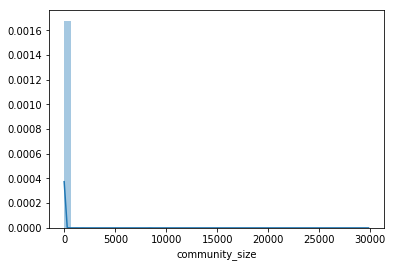

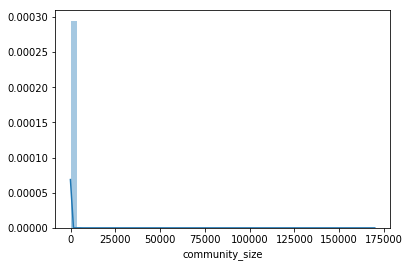

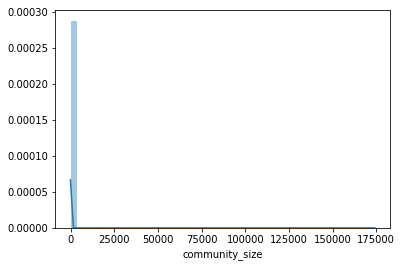

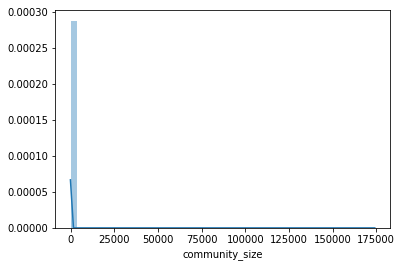

In [14]:
## Histogram of community size

# Get number of Louvain iterations run
n_iters = query_to_df("MATCH (a:NatureAuthor) RETURN size(a.louvain) as n_iters LIMIT 1", graph)['n_iters'][0]

# Plot histogram at each iteration
for i in range(n_iters):
    query = """
    MATCH (a:NatureAuthor) 
    RETURN 
        a.louvain[{}] as community_id, 
        COUNT(a) as community_size""".format(i)
    df = query_to_df(query, graph)
    plt.figure()
    sns.distplot(df['community_size'])

Number of authors: 293,023
Number of communities: 78,059
------------------------------

Statistics after iteration 1:
Number of communities: 101,488
Average community size: 2.887267460192338
Number of communities of size 1: 75,019
Percentage of communities of size 1: 0.7391908402963897
------------------------------
Statistics after iteration 2:
Number of communities: 78,059
Average community size: 3.7538656657143954
Number of communities of size 1: 74,807
Percentage of communities of size 1: 0.9583392049603505
------------------------------
Statistics after iteration 3:
Number of communities: 77,622
Average community size: 3.774999355852722
Number of communities of size 1: 74,807
Percentage of communities of size 1: 0.9637345082579681
------------------------------
Statistics after iteration 4:
Number of communities: 77,621
Average community size: 3.775047989590446
Number of communities of size 1: 74,807
Percentage of communities of size 1: 0.9637469241571224
------------------------

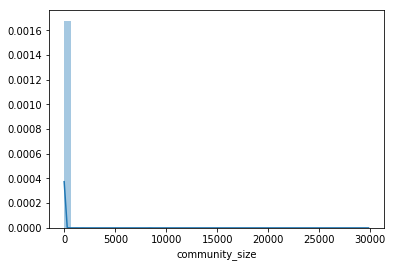

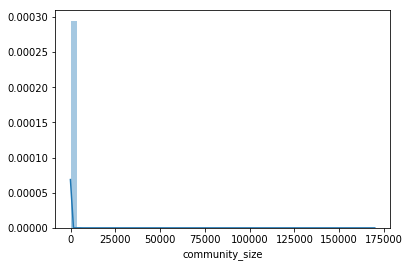

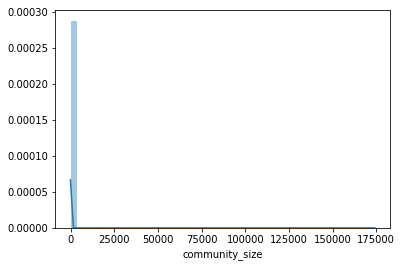

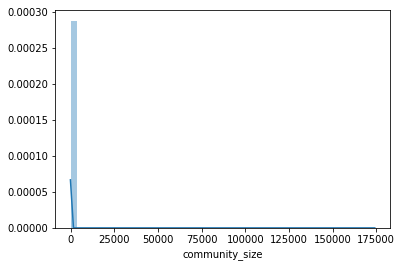

In [65]:
# Number of authors

d = graph.run("MATCH (a:NatureAuthor) RETURN COUNT(a) as number_of_nature_authors").data()[0]
num_nature_authors = d['number_of_nature_authors']
print("Number of authors: {:,}".format(num_nature_authors))

# Number of communities

d = graph.run("MATCH (a:NatureAuthor) RETURN COUNT(DISTINCT tail(a.louvain)) as number_of_communities").data()[0]
num_communities = d['number_of_communities']
print("Number of communities: {:,}".format(num_communities))
print("------------------------------\n")

# Distribution of community sizes

for i in range(n_iters):
    query = """
    MATCH (a:NatureAuthor) 
    RETURN 
        a.louvain[{}] as community_id, 
        COUNT(a) as community_size""".format(i)

    df = query_to_df(query, graph)
    
    d = graph.run("MATCH (a:NatureAuthor) RETURN COUNT(DISTINCT a.louvain[{}]) as number_of_communities".format(i)).data()[0]
    num_communities = d['number_of_communities']
    
    #d = graph.run("MATCH (a:NatureAuthor) RETURN COUNT(DISTINCT a.louvain[{}]) as number_of_communities".format(i)).data()[0]
    num_communities_size_1 = len(df.loc[df['community_size'] == 1].index)
    
    
    print("Statistics after iteration {}:".format(i+1))
    print("Number of communities: {:,}".format(num_communities))
    print("Average community size:", df['community_size'].mean())
    print("Number of communities of size 1: {:,}".format(num_communities_size_1))
    print("Percentage of communities of size 1: {}".format(num_communities_size_1/float(num_communities)))
    print("------------------------------")
    
    plt.figure()
    sns.distplot(df['community_size'])

In [ ]:
# Number of authors

d = graph.run("MATCH (a:NatureAuthor) RETURN COUNT(a) as number_of_nature_authors").data()[0]
num_nature_authors = d['number_of_nature_authors']
print("Number of authors: {:,}".format(num_nature_authors))

##### Distribution of community sizes #####

query = """
MATCH (a:NatureAuthor) 
RETURN 
    a.labelprop as community_id, 
    COUNT(a) as community_size""".format(i)

df = query_to_df(query, graph)
community_size_df = df['community_size']

d = graph.run("MATCH (a:NatureAuthor) RETURN COUNT(DISTINCT a.labelprop) as number_of_communities").data()[0]
num_communities = d['number_of_communities']
num_communities_size_1 = len(df.loc[community_size_df == 1].index)


print("Number of communities: {:,}".format(num_communities))
print("Average community size:", community_size_df.mean())
print("Number of communities of size 1: {:,}".format(num_communities_size_1))
print("Percentage of communities of size 1: {}".format(num_communities_size_1/float(num_communities)))
print("------------------------------\n")

plt.figure()
sns.distplot(community_size_df)

##### Coauthor Distributions #####

query = """MATCH (a:NatureAuthor)
WITH a, size((a)-[:COAUTHOR]-()) as Num_Coauthors
RETURN a.name, Num_Coauthors"""

df = query_to_df(query, graph)
degree_df = df['Num_Coauthors']

print("Coauthorship statistics:\n")
print(degree_df.describe())

plt.figure()
sns.distplot(degree_df)